In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf, tensorflow.keras.backend as K
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers
from glob import glob
import seaborn as sns

In [ ]:
AUTO = tf.data.experimental.AUTOTUNE
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

# GCS_DS_PATH = KaggleDatasets().get_gcs_path()

Running on TPU  grpc://10.67.139.234:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.67.139.234:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.67.139.234:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


REPLICAS:  8


In [ ]:
IMG_SIZE = 784
BATCH_SIZE = 8 * strategy.num_replicas_in_sync
nb_classes = 2

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/SNUBH_AI_project/Xray_OSA/real_data/df2_merge_toy.csv')
glob_image = glob('/content/drive/MyDrive/SNUBH_AI_project/Xray_OSA/real_data/raw_images_merge/*.jpg')
print(len(glob_image))
df

4698


,Unnamed: 0,case_id,hos_id,age,sex,cephalo_d,filename,ahi,ahi_osa,anyosa,modsev,set
0,1,ceph-00001,10003138,43,0,2017-12-22,10003138_20200610_20171222204955_Cephalometry.jpg,7.0,mild,1,0,train
1,2,ceph-00002,10013483,85,1,2015-05-08,10013483_20200609_20150508080420_Cephalometry.jpg,86.7,severe,1,1,train
2,3,ceph-00003,10024197,68,0,2017-02-22,10024197_20200608_20170222162813_Cephalometry.jpg,64.1,severe,1,1,train
3,4,ceph-00004,10036260,59,0,2019-11-18,10036260_20200609_20191118074354_Cephalometry.jpg,33.2,severe,1,1,train
4,5,ceph-00005,10048737,65,1,2016-04-18,10048737_20200608_20160418111134_Cephalometry.jpg,54.4,severe,1,1,test
...,...,...,...,...,...,...,...,...,...,...,...,...
4575,4576,ctrl-02286,10029743,66,0,2018-01-17,10029743_20200825_20180117144732_Cephalometry.jpg,NaN,no,0,0,test
4576,4577,ctrl-02287,11161741,59,1,2015-10-28,11161741_20200825_20151028151049_Cephalometry.jpg,NaN,no,0,0,train
4577,4578,ctrl-02288,31044686,68,0,2019-05-17,31044686_20200825_20190517115221_Cephalometry.jpg,NaN,no,0,0,train
4578,4579,ctrl-02289,17827258,61,1,2019-06-27,17827258_20200825_20190627092132_Cephalometry.jpg,NaN,no,0,0,test


In [ ]:
data_image_paths = {os.path.basename(x): x for x in glob_image}
df['path'] = df['filename'].map(data_image_paths.get)
df['ahi_osa'] = df['ahi_osa'].map(lambda x: x.replace('no', 'normal'))

In [ ]:
normal_images = glob_image
normal_data = {'path': normal_images, 'ahi_osa': 'Normal'}
df1 = pd.DataFrame(normal_data)
df = pd.concat([df,df1], ignore_index=True, axis=1)
df = df[[6, 8, 10, 11, 12]]
df = df.dropna(axis=0)
df.to_csv('last_check.csv')
df[8] = df[8].replace('normal', 'normal|mild')
df[8] = df[8].replace('mild', 'normal|mild')
df[8] = df[8].replace('moderate', 'moderate|severe')
df[8] = df[8].replace('severe', 'moderate|severe')
df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,1.0,ceph-00001,10003138.0,43.0,0.0,2017-12-22,10003138_20200610_20171222204955_Cephalometry.jpg,7.0,mild,1.0,0.0,train,/content/drive/MyDrive/SNUBH_AI_project/Xray_O...,/content/drive/MyDrive/SNUBH_AI_project/Xray_O...,Normal
1,2.0,ceph-00002,10013483.0,85.0,1.0,2015-05-08,10013483_20200609_20150508080420_Cephalometry.jpg,86.7,severe,1.0,1.0,train,/content/drive/MyDrive/SNUBH_AI_project/Xray_O...,/content/drive/MyDrive/SNUBH_AI_project/Xray_O...,Normal
2,3.0,ceph-00003,10024197.0,68.0,0.0,2017-02-22,10024197_20200608_20170222162813_Cephalometry.jpg,64.1,severe,1.0,1.0,train,/content/drive/MyDrive/SNUBH_AI_project/Xray_O...,/content/drive/MyDrive/SNUBH_AI_project/Xray_O...,Normal
3,4.0,ceph-00004,10036260.0,59.0,0.0,2019-11-18,10036260_20200609_20191118074354_Cephalometry.jpg,33.2,severe,1.0,1.0,train,/content/drive/MyDrive/SNUBH_AI_project/Xray_O...,/content/drive/MyDrive/SNUBH_AI_project/Xray_O...,Normal
4,5.0,ceph-00005,10048737.0,65.0,1.0,2016-04-18,10048737_20200608_20160418111134_Cephalometry.jpg,54.4,severe,1.0,1.0,test,/content/drive/MyDrive/SNUBH_AI_project/Xray_O...,/content/drive/MyDrive/SNUBH_AI_project/Xray_O...,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4693,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,/content/drive/MyDrive/SNUBH_AI_project/Xray_O...,Normal
4694,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,/content/drive/MyDrive/SNUBH_AI_project/Xray_O...,Normal
4695,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,/content/drive/MyDrive/SNUBH_AI_project/Xray_O...,Normal
4696,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,/content/drive/MyDrive/SNUBH_AI_project/Xray_O...,Normal


In [ ]:
train_df = df[df[11] == 'train']
valid_df = df[df[11] == 'valid']
test_df = df[df[11] == 'test']
train_df.sample(5)

,6,8,10,11,12,normal|mild,moderate|severe,osa_vec
2611,14759192_20200824_20150918133938_Cephalometry.jpg,normal|mild,0.0,train,/content/drive/MyDrive/SNUBH_AI_project/Xray_O...,1,0,"[1, 0]"
3989,23596674_20200825_20171026101452_Cephalometry.jpg,normal|mild,0.0,train,/content/drive/MyDrive/SNUBH_AI_project/Xray_O...,1,0,"[1, 0]"
2200,30789645_20200609_20190404071531_Cephalometry.jpg,moderate|severe,1.0,train,/content/drive/MyDrive/SNUBH_AI_project/Xray_O...,0,1,"[0, 1]"
724,18430842_20200610_20171018094759_Cephalometry.jpg,moderate|severe,1.0,train,/content/drive/MyDrive/SNUBH_AI_project/Xray_O...,0,1,"[0, 1]"
1592,26308333_20200608_20160601164611_Cephalometry.jpg,moderate|severe,1.0,train,/content/drive/MyDrive/SNUBH_AI_project/Xray_O...,0,1,"[0, 1]"


normal|mild        3026
moderate|severe    1554
Name: 8, dtype: int64


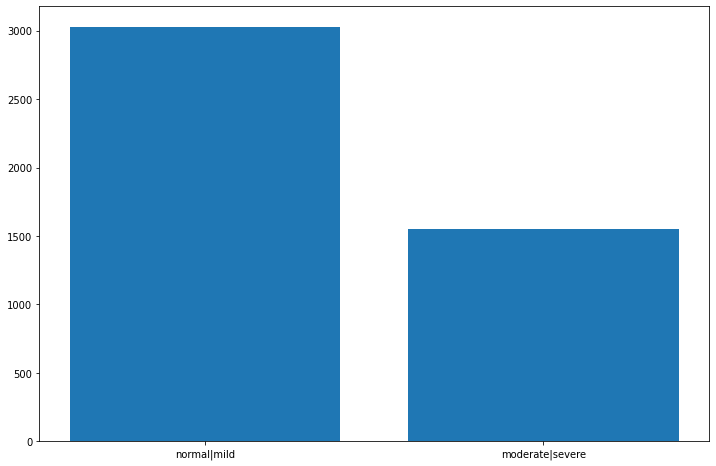

In [ ]:
label_counts = df[8].value_counts()
print(label_counts)
fig, ax1 = plt.subplots(1,1,figsize = (12, 8))
ax1.bar(np.arange(len(label_counts))+0.5, label_counts)
ax1.set_xticks(np.arange(len(label_counts))+0.5)
_ = ax1.set_xticklabels(label_counts.index, rotation = 0)

In [ ]:
all_labels = ['normal|mild', 'moderate|severe']
print('All Labels ({}): {}'.format(len(all_labels), all_labels))
for c_label in all_labels:
    if len(c_label) > 1: # leave out empty labels
        df[c_label] = df[8].map(lambda finding: 1 if c_label in finding else 0)

All Labels (2): ['normal|mild', 'moderate|severe']


In [ ]:
df['osa_vec'] = df.apply(lambda x: [x[all_labels].values], 1).map(lambda x: x[0])
df['osa_vec']

0       [1, 0]
1       [0, 1]
2       [0, 1]
3       [0, 1]
4       [0, 1]
         ...  
4575    [1, 0]
4576    [1, 0]
4577    [1, 0]
4578    [1, 0]
4579    [1, 0]
Name: osa_vec, Length: 4580, dtype: object

In [ ]:
df.shape

(4580, 8)

In [ ]:
path='/content/drive/MyDrive/SNUBH_AI_project/Xray_OSA/real_data/raw_images_merge'

train = df[6]
# train_id = df[8]

y_train = df[8]
category_names = ['normal|mild', 'moderate|severe']

# root = 'images'
images_paths = df[12]

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(df, y_train, test_size=0.2)

In [ ]:
labels = ['normal|mild', 'moderate|severe']

def compute_class_freqs(labels):
    
    N = len(labels)
    
    positive_frequencies = np.sum(labels, axis=0) / N
    negative_frequencies = 1 - positive_frequencies

    return positive_frequencies, negative_frequencies

In [ ]:
train_labels = []
ds_len = df.shape[0]

for inx in range(ds_len):
    row = df.iloc[inx]
    vec = np.array(row['osa_vec'], dtype=np.int)
    train_labels.append(vec)

[0.66069869 0.33930131]
[0.33930131 0.66069869]
             Class     Label     Value
0      normal|mild  Negative  0.660699
1  moderate|severe  Negative  0.339301
2      normal|mild  Positive  0.339301
3  moderate|severe  Positive  0.660699


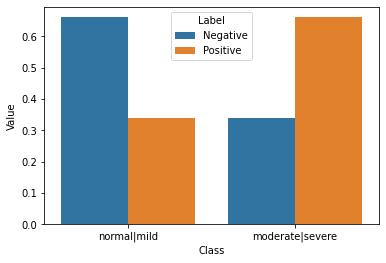

In [ ]:
freq_pos, freq_neg = compute_class_freqs(train_labels)
print(freq_pos), print(freq_neg)

data = pd.DataFrame({"Class": labels, "Label": "Negative", "Value": freq_pos})
data = data.append([{"Class": labels[l], "Label": "Positive", "Value": v} for l,v in enumerate(freq_neg)], ignore_index=True)
print(data)
plt.xticks(rotation=0)
f = sns.barplot(x="Class", y="Value", hue="Label" ,data=data)

In [ ]:
def weighted_loss(y_true, y_pred, pos_weights, neg_weights, epsilon=1e-7):

        # initialize loss to zero
        loss = 0.0

        for i in range(len(pos_weights)):
            # 각각 class 평균 loss weights를 준다.
            loss += -(torch.mean( pos_weights[i] * y_true[:,i] * torch.log(y_pred[:,i] + epsilon) + \
                                neg_weights[i] * (1 - y_true[:,i]) * torch.log(1 - y_pred[:,i] + epsilon), axis = 0))
            
        return loss

pos_weights = freq_neg
neg_weights = freq_pos
pos_contribution = freq_pos * pos_weights 
neg_contribution = freq_neg * neg_weights

             Class     Label     Value
0      normal|mild  Positive  0.224176
1  moderate|severe  Positive  0.224176
2      normal|mild  Negative  0.224176
3  moderate|severe  Negative  0.224176


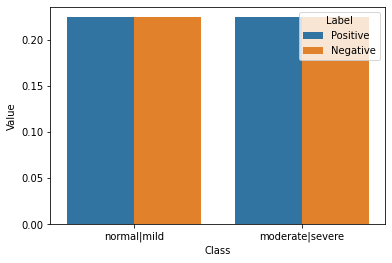

In [ ]:
data = pd.DataFrame({"Class": labels, "Label": "Positive", "Value": pos_contribution})
data = data.append([{"Class": labels[l], "Label": "Negative", "Value": v} 
                        for l,v in enumerate(neg_contribution)], ignore_index=True)
print(data)
plt.xticks(rotation=0)
sns.barplot(x="Class", y="Value", hue="Label" ,data=data)

In [ ]:
# from sklearn.utils.class_weight import compute_class_weight
# # class_weights = compute_class_weight('balanced', np.unique(y_train.argmax(axis=1)), y_train.argmax(axis=0))
# class_weights = compute_class_weight('balanced', np.unique(y_train.argmax), y_train.argmax)
# print('class weights: ',class_weights)

# plt.bar(range(2),1/class_weights,color=['normal|mild', 'moderate|severe'],width=0.9)
# plt.xticks(range(2), category_names) 

# plt.title("Loss weights");
# plt.ylabel('Probability')
# plt.xlabel('Data')
# plt.show()

# #class weights to dict
# c_w = dict(zip(range(2),class_weights))

In [ ]:
def decode_image(filename, label=None, image_size=(IMG_SIZE, IMG_SIZE)):
    bits = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(bits, channels=3)
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.image.resize(image, image_size)
    
    #convert to numpy and do some cv2 staff mb?
    
    if label is None:
        return image
    else:
        return image, label

def data_augment(image, label=None, seed=5050):
    image = tf.image.random_flip_left_right(image, seed=seed)
    image = tf.image.random_flip_up_down(image, seed=seed)
           
    if label is None:
        return image
    else:
        return image, label

In [ ]:
train_dataset = (
    tf.data.Dataset
    .from_tensor_slices((x_train, y_train))
    .map(decode_image, num_parallel_calls=AUTO)
    .map(data_augment, num_parallel_calls=AUTO)
    .repeat()
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
    )

ValueError: ignored

In [ ]:
val_dataset = (tf.data.Dataset
               .from_tensor_slices((x_val,y_val))
               .map(decode_image,num_parallel_calls=AUTO)
               .batch(BATCH_SIZE)
               .cache()
               .prefetch(AUTO)
              )

In [ ]:
!pip install efficientnet
import efficientnet.tfkeras as efn
import tensorflow as tf, tensorflow.keras.backend as K
from tensorflow.keras.layers import Dense,Dropout
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers

     |████████████████████████████████| 51kB 3.1MB/s 


In [ ]:
def get_model():
    base_model = efn.EfficientNetB7(weights='imagenet',
                          include_top=False,
                          input_shape=(IMG_SIZE,IMG_SIZE, 3),
                          pooling='avg')
    x = base_model.output
    predictions = Dense(nb_classes, activation="sigmoid")(x)
    return Model(inputs=base_model.input, outputs=predictions)

In [ ]:
from tensorflow.keras.optimizers import Adam

with strategy.scope():
    model = get_model()

opt = Adam(lr=0.001)
model.compile(optimizer=opt, loss='binary_crossentropy',metrics=['accuracy'])

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau

model_name = 'xrayosa.h5'

#good callbacks
best_model = ModelCheckpoint(model_name, monitor='val_loss', verbose=1, save_best_only=True,save_weights_only=True,mode='min')
reduce_lr = ReduceLROnPlateau(monitor='val_loss',factor=0.5,verbose=1,min_lr=0.000001,patience=6)

In [ ]:
train_df1 = []
for tr in train_df[6]:
    train_df1.append(tr)

['10003138_20200610_20171222204955_Cephalometry.jpg',
 '10013483_20200609_20150508080420_Cephalometry.jpg',
 '10024197_20200608_20170222162813_Cephalometry.jpg',
 '10036260_20200609_20191118074354_Cephalometry.jpg',
 '10082124_20200609_20141125134145_Cephalometry.jpg']

In [ ]:
valid_df1 = []
for vl in valid_df[6]:
    valid_df1.append(vl)

valid_df1[:5]

['10049956_20200609_20150728152748_Cephalometry.jpg',
 '10065028_20200609_20190104085331_Cephalometry.jpg',
 '10091407_20200608_20170203135806_Cephalometry.jpg',
 '10146554_20200609_20181227074254_Cephalometry.jpg',
 '10162859_20200609_20181012114552_Cephalometry.jpg']

In [ ]:
print(len(train_df1))

2764


In [ ]:
print(y_train.shape)
print(BATCH_SIZE)
len(train_df1)

(3664,)
64


2764

In [ ]:
3664 / 64

57.25

In [ ]:
# history = model.fit(train_df,
#                     steps_per_epoch=y_train.shape[0]//BATCH_SIZE,
#                     epochs=5,
#                     verbose=1,
#                     validation_data=valid_df,
#                     callbacks=[reduce_lr,best_model]
#                     )

history = model.fit(train_df1,
                    steps_per_epoch=y_train.shape[0]//BATCH_SIZE,
                    epochs=5,
                    verbose=1,
                    validation_data=valid_df1
                    )

Epoch 1/5
Instructions for updating:
Use `tf.data.Iterator.get_next_as_optional()` instead.


Instructions for updating:
Use `tf.data.Iterator.get_next_as_optional()` instead.


ValueError: ignored

In [ ]:
plt.title('model accuracy')
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
path='../input/plant-pathology-2020-fgvc7/'

test = pd.read_csv(path+'test.csv')
test_id = test['image_id']

root = 'images'
x_test = [(os.path.join(GCS_DS_PATH,root,idee+'.jpg')) for idee in test_id]

In [ ]:
model.load_weights(model_name)

In [ ]:
test_dataset = (
    tf.data.Dataset
    .from_tensor_slices(x_test)
    .map(decode_image, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
)

In [ ]:
y_pred = model.predict(test_dataset,verbose=1)

In [ ]:
def save_results(y_pred):
    
    path='../input/plant-pathology-2020-fgvc7/'
    test = pd.read_csv(path + 'test.csv')
    test_id = test['image_id']

    res = pd.read_csv(path+'train.csv')
    res['image_id'] = test_id
  
    labels = res.keys()

    for i in range(1,5):
        res[labels[i]] = y_pred[:,i-1]

    res.to_csv('submission.csv',index=False)
  
    print(res.head)

In [ ]:
save_results(y_pred)